**Table of contents**<a id='toc0_'></a>    
- [<b> Import Libraries </b>](#toc1_)    
    - [Load configuration file](#toc1_1_1_)    
    - [Load Train and Valid set](#toc1_1_2_)    
- [<b>Fitting Model</b>](#toc2_)    
    - [Baseline Mean Model](#toc2_1_1_)    
    - [Weight Model](#toc2_1_2_)    
- [<B>Baseline ML Model</b>](#toc3_)    
  - [Create Training Log](#toc3_1_)    
  - [Create Multiple Model Objects](#toc3_2_)    
  - [Create Fitting Function](#toc3_3_)    
  - [Training Model](#toc3_4_)    
  - [Create function to save production model](#toc3_5_)    
  - [Save Best model and Update Training Logs](#toc3_6_)    
  - [Baseline Model Overview](#toc3_7_)    
  - [Top Baseline Model](#toc3_8_)    
- [<b>Hyperparams</b>](#toc4_)    
  - [Gradient Boosting Oversampling](#toc4_1_)    
    - [Oversampling](#toc4_1_1_)    
    - [Smote](#toc4_1_2_)    
    - [ROC Curve Gradient Boosting on SMOTE and Oversampling](#toc4_1_3_)    
  - [Random Forest](#toc4_2_)    
    - [Smote](#toc4_2_1_)    
  - [XGBOOST Classifier](#toc4_3_)    
    - [Smote](#toc4_3_1_)    
    - [Oversampling](#toc4_3_2_)    
  - [Decision Tree](#toc4_4_)    
    - [Smote](#toc4_4_1_)    
  - [ADABOOST](#toc4_5_)    
    - [Smote](#toc4_5_1_)    
  - [<b>ROC Plot (Auc Score)</b>](#toc4_6_)    
- [<b> Hyperparameter Tuning</b>](#toc5_)    
  - [Create Param Distribution](#toc5_1_)    
    - [run debugging](#toc5_1_1_)    
  - [Create Training Function based on Validation](#toc5_2_)    
  - [Training model and update Training Logs](#toc5_3_)    
  - [Best Model Overview](#toc5_4_)    
- [<b>Test Data</b>](#toc6_)    
  - [Create ROC Curve toward Test Set](#toc6_1_)    
  - [Create Function to Eval Test Data](#toc6_2_)    
  - [Training Dataset and Update Training Logs](#toc6_3_)    
  - [Check Best Model](#toc6_4_)    
  - [Save Production Model](#toc6_5_)    
- [<b>Show Best Final Model</b>](#toc7_)    
- [<b> Check Production Model</b>](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[<b> Import Libraries </b>](#toc0_)

In [2]:
import src.util as util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import hashlib
import json

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

### <a id='toc1_1_1_'></a>[Load configuration file](#toc0_)

In [3]:
config_data = util.load_config()

### <a id='toc1_1_2_'></a>[Load Train and Valid set](#toc0_)

In [4]:
## Load function to call dataset
def load_train_clean(params: dict) -> pd.DataFrame:
    x_train = util.pickle_load(params["train_set_clean"][0])
    y_train = util.pickle_load(params["train_set_clean"][1])

    return x_train, y_train

def load_valid_clean(params:dict) -> pd.DataFrame:
    x_valid = util.pickle_load(params["valid_set_clean"][0])
    y_valid = util.pickle_load(params["valid_set_clean"][1])

    return x_valid, y_valid

def load_test_clean(params: dict) -> pd.DataFrame:
    x_test = util.pickle_load(params["test_set_clean"][0])
    y_test = util.pickle_load(params["test_set_clean"][1])

    return x_test, y_test

In [5]:
x_train, y_train = load_train_clean(config_data)
x_valid, y_valid = load_valid_clean(config_data)
x_test, y_test = load_test_clean(config_data)

# <a id='toc2_'></a>[<b>Fitting Model</b>](#toc0_)
------

### <a id='toc2_1_1_'></a>[Baseline Mean Model](#toc0_)

In [6]:
def Baseline_model():
    dummy_clf = DummyClassifier(strategy='stratified')

    dummy_clf.fit(x_train["nonbalance"], y_train["nonbalance"])

    y_pred = dummy_clf.predict(x_train["nonbalance"])

    report = classification_report(y_true = y_train["nonbalance"],
                                    y_pred = y_pred,
                                    output_dict = True)
    report = pd.DataFrame(report)
    return report

In [7]:
## Show the baseline model of raw dataset
report = Baseline_model()

report["macro avg"]["f1-score"]

0.5168265981889445

### <a id='toc2_1_2_'></a>[Weight Model](#toc0_)

In [8]:
def add_weight():
    sklearn_weight = compute_class_weight(class_weight = 'balanced', 
                                            classes = np.unique(y_train["nonbalance"]), 
                                            y = y_train["nonbalance"])
    sklearn_weight = dict(zip(np.unique(y_train["nonbalance"]), sklearn_weight))

    util.pickle_dump(sklearn_weight, config_data['model_params_path'][0])

    return sklearn_weight

In [9]:
sklearn_weight = add_weight()
sklearn_weight

{0: 0.6644518272425249, 1: 2.0202020202020203}

# <a id='toc3_'></a>[<B>Baseline ML Model</b>](#toc0_)
----

## <a id='toc3_1_'></a>[Create Training Log](#toc0_)

In [10]:
## Create Training log function
def training_log_template() -> dict:
    # Debug message
    util.print_debug("creating training log template.")

    # Template of training log
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
         "data_configurations" : [],
    }

    # Debug message
    util.print_debug("Training log template created.")

    # Return training log template
    return logger

In [11]:
## Create training log updater
def training_log_updater(current_log: dict, params: dict) -> list:
    # Create copy of current log
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found, create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    # Return log
    return last_log


## <a id='toc3_2_'></a>[Create Multiple Model Objects](#toc0_)
---------------

In [36]:
## Create model object of machine learning model
def create_model_object(params: dict) -> list:
    # Debug message
    util.print_debug("Creating model objects.")

    # Create model objects
    # baseline_knn = KNeighborsClassifier()
    baseline_dt = DecisionTreeClassifier()
    baseline_logreg = LogisticRegression()
    baseline_svm = SVC()
    baseline_rforest = RandomForestClassifier()
    baseline_ada = AdaBoostClassifier()
    baseline_grad = GradientBoostingClassifier()
    baseline_xgb = XGBClassifier()
    baseline_qda = QuadraticDiscriminantAnalysis()
    baseline_gnb = GaussianNB()

    # Create list of model
    list_of_model = [
        # { "model_name": baseline_knn.__class__.__name__, "model_object": baseline_knn, "model_uid": ""},
        { "model_name": baseline_dt.__class__.__name__, "model_object": baseline_dt, "model_uid": ""},
        { "model_name": baseline_logreg.__class__.__name__, "model_object": baseline_logreg, "model_uid": ""},
        { "model_name": baseline_svm.__class__.__name__, "model_object": baseline_svm, "model_uid": ""},
        { "model_name": baseline_rforest.__class__.__name__, "model_object": baseline_rforest, "model_uid": ""},
        { "model_name": baseline_ada.__class__.__name__, "model_object": baseline_ada, "model_uid": ""},
        { "model_name": baseline_grad.__class__.__name__, "model_object": baseline_grad, "model_uid": ""},
        { "model_name": baseline_xgb.__class__.__name__, "model_object": baseline_xgb, "model_uid": ""},
        { "model_name": baseline_qda.__class__.__name__, "model_object": baseline_qda, "model_uid": ""},
        { "model_name": baseline_gnb.__class__.__name__, "model_object": baseline_gnb, "model_uid": ""},
    ]

    # Debug message
    util.print_debug("Model objects created.")

    # Return the list of model
    return list_of_model

## <a id='toc3_3_'></a>[Create Fitting Function](#toc0_)
------

In [33]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]
        x_valid_data = x_valid[config_data]
        y_valid_data = y_valid[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_valid_data)
            performance = classification_report(y_valid_data, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["f1-score"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

## <a id='toc3_4_'></a>[Training Model](#toc0_)

In [37]:
list_of_trained_model, training_log = train_eval("", config_data)

2023-07-30 13:15:24.787753 creating training log template.
2023-07-30 13:15:24.787753 Training log template created.
2023-07-30 13:15:24.787753 Training model based on configuration data: nonbalance
2023-07-30 13:15:24.787753 Creating model objects.
2023-07-30 13:15:24.788752 Model objects created.
2023-07-30 13:15:24.788752 Training model: DecisionTreeClassifier
2023-07-30 13:15:24.800503 Evalutaing model: DecisionTreeClassifier
2023-07-30 13:15:24.810554 Logging: DecisionTreeClassifier
2023-07-30 13:15:24.810554 Model DecisionTreeClassifier has been trained for configuration data nonbalance.
2023-07-30 13:15:24.810554 Training model: LogisticRegression
2023-07-30 13:15:24.827649 Evalutaing model: LogisticRegression
2023-07-30 13:15:24.838711 Logging: LogisticRegression
2023-07-30 13:15:24.839710 Model LogisticRegression has been trained for configuration data nonbalance.
2023-07-30 13:15:24.839710 Training model: SVC
2023-07-30 13:15:24.884975 Evalutaing model: SVC
2023-07-30 13:15:2

c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


2023-07-30 13:15:26.458996 Evalutaing model: SVC
2023-07-30 13:15:26.480943 Logging: SVC
2023-07-30 13:15:26.481932 Model SVC has been trained for configuration data smote.
2023-07-30 13:15:26.481932 Training model: RandomForestClassifier
2023-07-30 13:15:26.853452 Evalutaing model: RandomForestClassifier
2023-07-30 13:15:26.871098 Logging: RandomForestClassifier
2023-07-30 13:15:26.884734 Model RandomForestClassifier has been trained for configuration data smote.
2023-07-30 13:15:26.884734 Training model: AdaBoostClassifier
2023-07-30 13:15:27.071973 Evalutaing model: AdaBoostClassifier
2023-07-30 13:15:27.090016 Logging: AdaBoostClassifier
2023-07-30 13:15:27.094058 Model AdaBoostClassifier has been trained for configuration data smote.
2023-07-30 13:15:27.094058 Training model: GradientBoostingClassifier
2023-07-30 13:15:27.630496 Evalutaing model: GradientBoostingClassifier
2023-07-30 13:15:27.638311 Logging: GradientBoostingClassifier
2023-07-30 13:15:27.646267 Model GradientBoost

c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


2023-07-30 13:15:28.086959 Evalutaing model: SVC
2023-07-30 13:15:28.109809 Logging: SVC
2023-07-30 13:15:28.109809 Model SVC has been trained for configuration data oversampling.
2023-07-30 13:15:28.109809 Training model: RandomForestClassifier
2023-07-30 13:15:28.463047 Evalutaing model: RandomForestClassifier
2023-07-30 13:15:28.480287 Logging: RandomForestClassifier
2023-07-30 13:15:28.491649 Model RandomForestClassifier has been trained for configuration data oversampling.
2023-07-30 13:15:28.491649 Training model: AdaBoostClassifier
2023-07-30 13:15:28.667886 Evalutaing model: AdaBoostClassifier
2023-07-30 13:15:28.688680 Logging: AdaBoostClassifier
2023-07-30 13:15:28.691645 Model AdaBoostClassifier has been trained for configuration data oversampling.
2023-07-30 13:15:28.691645 Training model: GradientBoostingClassifier
2023-07-30 13:15:29.114860 Evalutaing model: GradientBoostingClassifier
2023-07-30 13:15:29.123517 Logging: GradientBoostingClassifier
2023-07-30 13:15:29.13010

c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## <a id='toc3_5_'></a>[Create function to save production model](#toc0_)

In [38]:
def get_production_model(list_of_model, training_log, params):
    # Create copy list of model
    list_of_model = copy.deepcopy(list_of_model)
    
    # Debug message
    util.print_debug("Choosing model by metrics score.")

    # Create required predefined variabel
    curr_production_model = None
    prev_production_model = None
    production_model_log = None

    # Debug message
    util.print_debug("Converting training log type of data from dict to dataframe.")

    # Convert dictionary to pandas for easy operation
    training_log = pd.DataFrame(copy.deepcopy(training_log))

    # Debug message
    util.print_debug("Trying to load previous production model.")

    # Check if there is a previous production model
    try:
        prev_production_model = util.pickle_load(params["production_model_path"])
        util.print_debug("Previous production model loaded.")

    except FileNotFoundError as fe:
        util.print_debug("No previous production model detected, choosing best model only from current trained model.")

    # If previous production model detected:
    if prev_production_model != None:
        # Debug message
        util.print_debug("Loading validation data.")
        x_valid, y_valid
        
        # Debug message
        util.print_debug("Checking compatibilty previous production model's input with current train data's features.")

        # Check list features of previous production model and current dataset
        production_model_features = set(prev_production_model["model_data"]["model_object"].feature_names_in_)
        current_dataset_features = set(x_valid.columns)
        number_of_different_features = len((production_model_features - current_dataset_features) | (current_dataset_features - production_model_features))

        # If feature matched:
        if number_of_different_features == 0:
            # Debug message
            util.print_debug("Features compatible.")

            # Debug message
            util.print_debug("Reassesing previous model performance using current validation data.")

            # Re-predict previous production model to provide valid metrics compared to other current models
            y_pred = prev_production_model["model_data"]["model_object"].predict(x_valid)

            # Re-asses prediction result
            eval_res = classification_report(y_valid, y_pred, output_dict = True)

            # Debug message
            util.print_debug("Assessing complete.")

            # Debug message
            util.print_debug("Storing new metrics data to previous model structure.")

            # Update their performance log
            prev_production_model["model_log"]["performance"] = eval_res
            prev_production_model["model_log"]["f1_score_avg"] = eval_res["weighted avg"]["recall"]

            # Debug message
            util.print_debug("Adding previous model data to current training log and list of model")

            # Added previous production model log to current logs to compere who has the greatest f1 score
            training_log = pd.concat([training_log, pd.DataFrame([prev_production_model["model_log"]])])

            # Added previous production model to current list of models to choose from if it has the greatest f1 score
            list_of_model["prev_production_model"] = [copy.deepcopy(prev_production_model["model_data"])]
        else:
            # To indicate that we are not using previous production model
            prev_production_model = None

            # Debug message
            util.print_debug("Different features between production model with current dataset is detected, ignoring production dataset.")

    # Debug message
    util.print_debug("Sorting training log by f1 macro avg and training time.")

    # Sort training log by f1 score macro avg and trining time
    best_model_log = training_log.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    # Debug message
    util.print_debug("Searching model data based on sorted training log.")

    # Get model object with greatest f1 score macro avg by using UID
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_log["model_uid"]:
                curr_production_model = dict()
                curr_production_model["model_data"] = copy.deepcopy(model_data)
                curr_production_model["model_log"] = copy.deepcopy(best_model_log.to_dict())
                curr_production_model["model_log"]["model_name"] = "Production-{}".format(curr_production_model["model_data"]["model_name"])
                curr_production_model["model_log"]["training_date"] = str(curr_production_model["model_log"]["training_date"])
                production_model_log = training_log_updater(curr_production_model["model_log"], params)
                break
    
    # In case UID not found
    if curr_production_model == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    # Debug message
    util.print_debug("Model chosen.")

    # Dump chosen production model
    util.pickle_dump(curr_production_model, params["production_model_path"])
    
    # Return current chosen production model, log of production models and current training log
    return curr_production_model, production_model_log, training_log

## <a id='toc3_6_'></a>[Save Best model and Update Training Logs](#toc0_)

In [39]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, config_data)

2023-07-30 13:15:38.316342 Choosing model by metrics score.
2023-07-30 13:15:38.316848 Converting training log type of data from dict to dataframe.
2023-07-30 13:15:38.335110 Trying to load previous production model.
2023-07-30 13:15:38.335110 No previous production model detected, choosing best model only from current trained model.
2023-07-30 13:15:38.335110 Sorting training log by f1 macro avg and training time.
2023-07-30 13:15:38.338643 Searching model data based on sorted training log.
2023-07-30 13:15:38.380305 Model chosen.


## <a id='toc3_7_'></a>[Baseline Model Overview](#toc0_)

In [40]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
training_logs[["model_name", "performance", "f1_score_avg"]].sort_values(["f1_score_avg"], ascending=False)

,model_name,performance,f1_score_avg
14,-smote-GradientBoostingClassifier,"{'0': {'precision': 0.9523809523809523, 'recall': 0.8, 'f1-score': 0.8695652173913043, 'support': 75.0}, '1': {'precision': 0.8275862068965517, 'recall': 0.96, 'f1-score': 0.888888888888889, 'support': 75.0}, 'accuracy': 0.88, 'macro avg': {'precision': 0.8899835796387521, 'recall': 0.88, 'f1-score': 0.8792270531400966, 'support': 150.0}, 'weighted avg': {'precision': 0.8899835796387521, 'recall': 0.88, 'f1-score': 0.8792270531400966, 'support': 150.0}}",0.879227
12,-smote-RandomForestClassifier,"{'0': {'precision': 0.9230769230769231, 'recall': 0.8, 'f1-score': 0.8571428571428571, 'support': 75.0}, '1': {'precision': 0.8235294117647058, 'recall': 0.9333333333333333, 'f1-score': 0.8749999999999999, 'support': 75.0}, 'accuracy': 0.8666666666666667, 'macro avg': {'precision': 0.8733031674208145, 'recall': 0.8666666666666667, 'f1-score': 0.8660714285714285, 'support': 150.0}, 'weighted avg': {'precision': 0.8733031674208146, 'recall': 0.8666666666666667, 'f1-score': 0.8660714285714285, 'support': 150.0}}",0.866071
13,-smote-AdaBoostClassifier,"{'0': {'precision': 0.8732394366197183, 'recall': 0.8266666666666667, 'f1-score': 0.8493150684931506, 'support': 75.0}, '1': {'precision': 0.8354430379746836, 'recall': 0.88, 'f1-score': 0.8571428571428572, 'support': 75.0}, 'accuracy': 0.8533333333333334, 'macro avg': {'precision': 0.8543412372972009, 'recall': 0.8533333333333333, 'f1-score': 0.8532289628180039, 'support': 150.0}, 'weighted avg': {'precision': 0.8543412372972009, 'recall': 0.8533333333333334, 'f1-score': 0.8532289628180039, 'support': 150.0}}",0.853229
15,-smote-XGBClassifier,"{'0': {'precision': 0.8823529411764706, 'recall': 0.8, 'f1-score': 0.8391608391608392, 'support': 75.0}, '1': {'precision': 0.8170731707317073, 'recall': 0.8933333333333333, 'f1-score': 0.8535031847133757, 'support': 75.0}, 'accuracy': 0.8466666666666667, 'macro avg': {'precision': 0.8497130559540889, 'recall': 0.8466666666666667, 'f1-score': 0.8463320119371074, 'support': 150.0}, 'weighted avg': {'precision': 0.8497130559540889, 'recall': 0.8466666666666667, 'f1-score': 0.8463320119371074, 'support': 150.0}}",0.846332
23,-oversampling-GradientBoostingClassifier,"{'0': {'precision': 0.8591549295774648, 'recall': 0.8133333333333334, 'f1-score': 0.8356164383561644, 'support': 75.0}, '1': {'precision': 0.8227848101265823, 'recall': 0.8666666666666667, 'f1-score': 0.8441558441558442, 'support': 75.0}, 'accuracy': 0.84, 'macro avg': {'precision': 0.8409698698520236, 'recall': 0.8400000000000001, 'f1-score': 0.8398861412560044, 'support': 150.0}, 'weighted avg': {'precision': 0.8409698698520235, 'recall': 0.84, 'f1-score': 0.8398861412560042, 'support': 150.0}}",0.839886
22,-oversampling-AdaBoostClassifier,"{'0': {'precision': 0.8450704225352113, 'recall': 0.8, 'f1-score': 0.821917808219178, 'support': 75.0}, '1': {'precision': 0.810126582278481, 'recall': 0.8533333333333334, 'f1-score': 0.8311688311688312, 'support': 75.0}, 'accuracy': 0.8266666666666667, 'macro avg': {'precision': 0.8275985024068462, 'recall': 0.8266666666666667, 'f1-score': 0.8265433196940046, 'support': 150.0}, 'weighted avg': {'precision': 0.8275985024068462, 'recall': 0.8266666666666667, 'f1-score': 0.8265433196940046, 'support': 150.0}}",0.826543
6,-nonbalance-XGBClassifier,"{'0': {'precision': 0.9, 'recall': 0.84, 'f1-score': 0.8689655172413793, 'support': 75.0}, '1': {'precision': 0.6, 'recall': 0.72, 'f1-score': 0.6545454545454547, 'support': 25.0}, 'accuracy': 0.81, 'macro avg': {'precision': 0.75, 'recall': 0.78, 'f1-score': 0.761755485893417, 'support': 100.0}, 'weighted avg': {'precision': 0.825, 'recall': 0.81, 'f1-score': 0.815360501567398, 'support': 100.0}}",0.815361
24,-oversampling-XGBClassifier,"{'0': {'precision': 0.7831325301204819, 'recall': 0.8666666666666667, 'f1-score': 0.8227848101265823, 'support': 75.0}, '1': {'precision': 0.8507462686567164, 'recall': 0.76, 'f1-score': 0.80281690140845

## <a id='toc3_8_'></a>[Top Baseline Model](#toc0_)

In [41]:
print(training_logs[["model_name","f1_score_avg"]].sort_values(["f1_score_avg"], ascending=False).model_name.iloc[0:7])

util.print_debug(message="Based on training logs we can choose 7 top models.")

14           -smote-GradientBoostingClassifier
12               -smote-RandomForestClassifier
13                   -smote-AdaBoostClassifier
15                        -smote-XGBClassifier
23    -oversampling-GradientBoostingClassifier
22            -oversampling-AdaBoostClassifier
6                    -nonbalance-XGBClassifier
Name: model_name, dtype: object
2023-07-30 13:16:10.612343 Based on training logs we can choose 6 top models.


# <a id='toc4_'></a>[<b>Hyperparams</b>](#toc0_)
----

## <a id='toc4_1_'></a>[Gradient Boosting Oversampling](#toc0_)

### <a id='toc4_1_1_'></a>[Oversampling](#toc0_)
-------

In [121]:
# d_tree = DecisionTreeClassifier(max_depth=2)
n_estimators = [1,5,10,30,50,70,100,150,200,250]
max_depth = np.arange(2,11,1)
learning_rate = np.arange(0.1,1,0.1)

param_grid = {
        "n_estimators": n_estimators,
        "learning_rate" : learning_rate,
        "max_depth" : max_depth,
        }

# Buat gridsearch
grad_tree = GradientBoostingClassifier()

grad_tree_cv = RandomizedSearchCV(
                        estimator = grad_tree,
                        param_distributions = param_grid,
                        cv = 5,
                        scoring = "roc_auc",
                        n_jobs = -1)

grad_tree_cv.fit(x_train["oversampling"],y_train["oversampling"])

In [128]:
grad_tree = GradientBoostingClassifier(
                                    max_depth = grad_tree_cv.best_params_['max_depth'],
                                    n_estimators = grad_tree_cv.best_params_['n_estimators'],
                                    learning_rate = grad_tree_cv.best_params_['learning_rate'],
                                    random_state=123)


grad_tree.fit(x_train["oversampling"], y_train["oversampling"])

GradientBoostingClassifier(learning_rate=0.2, max_depth=10, n_estimators=200,
                           random_state=123)

In [131]:
y_valid_gb_pred_over = grad_tree.predict(x_valid['oversampling'])

print(classification_report(y_true = y_valid['oversampling'],
                            y_pred = y_valid_gb_pred_over))

              precision    recall  f1-score   support

           0       0.72      0.84      0.78        75
           1       0.81      0.68      0.74        75

    accuracy                           0.76       150
   macro avg       0.77      0.76      0.76       150
weighted avg       0.77      0.76      0.76       150



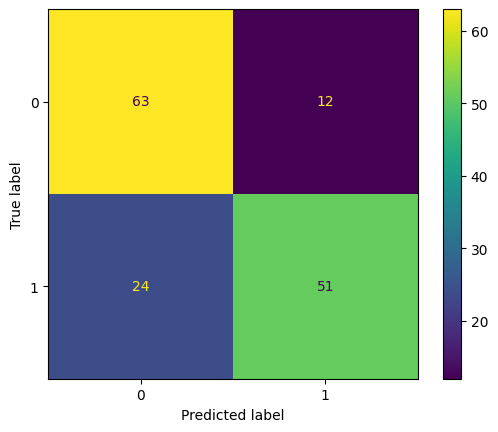

In [130]:
# Create confusion matrix list
disp_cm = list()

cm_gb_over = confusion_matrix(y_true = y_valid['oversampling'],
                            y_pred = y_valid_gb_pred_over)

disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_gb_over,
                               display_labels=grad_tree.classes_)
disp_cm.append(disp_1)

disp_1.plot()
plt.show()

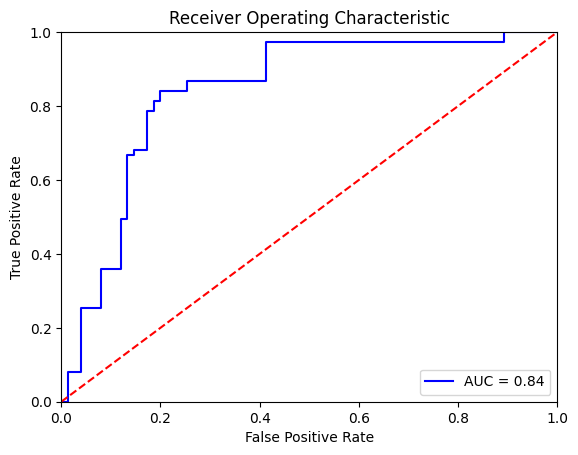

In [132]:
y_valid_gb_pred_over_proba = grad_tree.predict_proba(x_valid['oversampling'])

fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_valid['oversampling'],
                                         y_valid_gb_pred_over_proba[:, 1])
roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC = %0.2f' % roc_auc_gb_over)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### <a id='toc4_1_2_'></a>[Smote](#toc0_)
----

In [108]:
n_estimators = [1,5,10,30,50,70,100,150,200,250]
max_depth = np.arange(2,11,1)
learning_rate = np.arange(0.1,1,0.1)

param_grid = {
        "n_estimators": n_estimators,
        "learning_rate" : learning_rate,
        "max_depth" : max_depth
        }


grad_tree_cv = GridSearchCV(
                        estimator = grad_tree,
                        param_grid = param_grid,
                        cv = 5,
                        scoring = "roc_auc",
                        n_jobs = -1)

grid_result = grad_tree_cv.fit(x_train["smote"], y_train["smote"])

In [174]:
# Manual Hyperparameter Tuning
grad_tree_smote = GradientBoostingClassifier(
                                    max_depth = 7,
                                    n_estimators = 30,
                                    learning_rate = 0.2,
                                    random_state=123)

grad_tree_smote.fit(x_train["smote"], y_train["smote"])

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=30,
                           random_state=123)

In [175]:
## Classification Report
y_valid_gb_pred_smote = grad_tree_smote.predict(x_valid['smote'])

print(classification_report(y_true = y_valid['smote'],
                            y_pred = y_valid_gb_pred_smote))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86        75
           1       0.83      0.92      0.87        75

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



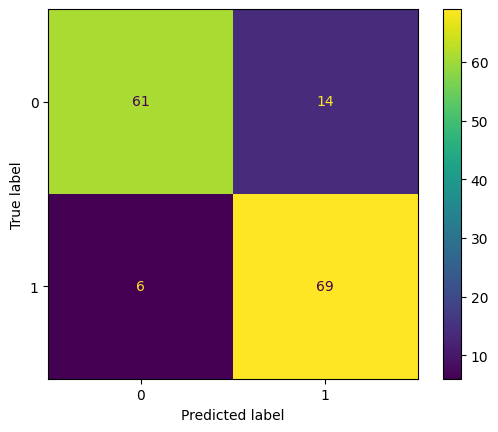

In [176]:
cm_gb_smote = confusion_matrix(y_true = y_valid['smote'],
                            y_pred = y_valid_gb_pred_smote)

disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_gb_smote,
                               display_labels=grad_tree.classes_)

disp_cm.append(disp_2)

disp_2.plot()
plt.show()

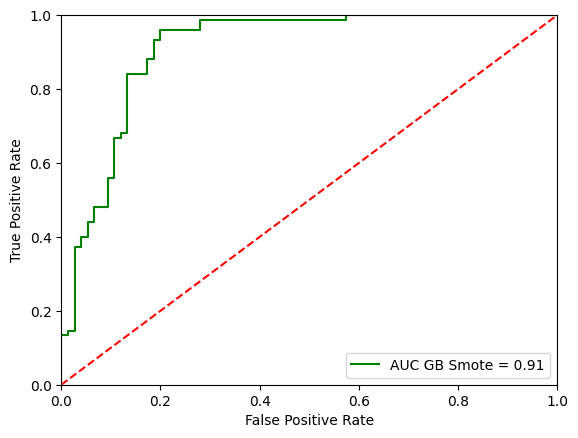

In [177]:
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_valid['smote'])
fpr_gb_smote, tpr_gb_smote, threshold_gb_smote = roc_curve(y_valid['smote'],
                                         y_valid_gb_pred_smote_proba[:, 1])
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GB Smote = %0.2f' % roc_auc_gb_smote)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### <a id='toc4_1_3_'></a>[ROC Curve Gradient Boosting on SMOTE and Oversampling](#toc0_)
---------

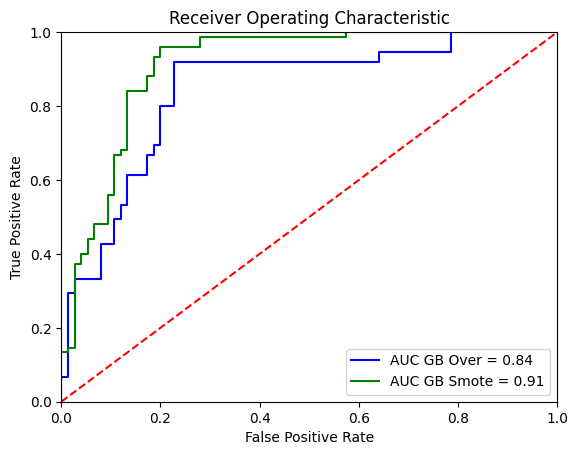

In [118]:
y_valid_gb_pred_over_proba = grad_tree.predict_proba(x_valid['oversampling'])
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_valid['smote'])

fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_valid['oversampling'],
                                         y_valid_gb_pred_over_proba[:, 1])

fpr_gb_smote, tpr_gb_smote, threshold_gb_smote = roc_curve(y_valid['smote'],
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC GB Over = %0.2f' % roc_auc_gb_over)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GB Smote = %0.2f' % roc_auc_gb_smote)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# util.pickle_dump(grad_tree, config_data['model_params_path'][4])

## <a id='toc4_2_'></a>[Random Forest](#toc0_)

### <a id='toc4_2_1_'></a>[Smote](#toc0_)
---------

In [161]:
# Manual Hyperparameter Tuning
rf_tree_smote = RandomForestClassifier(
                                    criterion='entropy',
                                    n_estimators = 250,
                                    random_state=123)

rf_tree_smote.fit(x_train["smote"], y_train["smote"])

RandomForestClassifier(criterion='entropy', n_estimators=250, random_state=123)

In [162]:
## Classification Report
y_valid_rf_pred_smote = rf_tree_smote.predict(x_valid['smote'])

print(classification_report(y_true = y_valid['smote'],
                            y_pred = y_valid_rf_pred_smote))

              precision    recall  f1-score   support

           0       0.92      0.81      0.87        75
           1       0.83      0.93      0.88        75

    accuracy                           0.87       150
   macro avg       0.88      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



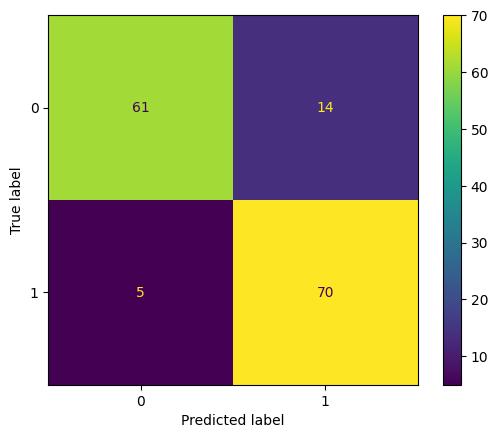

In [165]:
rf_gb_smote = confusion_matrix(y_true = y_valid['smote'],
                            y_pred = y_valid_rf_pred_smote)

disp_2 = ConfusionMatrixDisplay(confusion_matrix=rf_gb_smote,
                               display_labels=rf_tree_smote.classes_)

disp_cm.append(disp_2)

disp_2.plot()
plt.show()

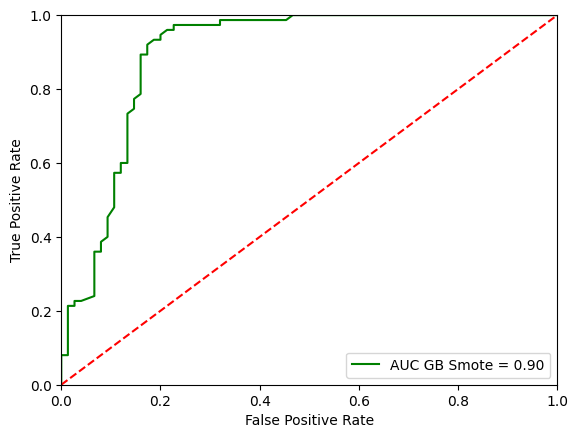

In [164]:
y_valid_rf_pred_smote_proba = rf_tree_smote.predict_proba(x_valid['smote'])

fpr_fr_smote, tpr_fr_smote, _ = roc_curve(y_valid['smote'],
                                         y_valid_rf_pred_smote_proba[:, 1])

roc_auc_rf_smote = auc(fpr_fr_smote, tpr_fr_smote)

plt.plot(fpr_fr_smote, tpr_fr_smote, 'g', label = 'AUC GB Smote = %0.2f' % roc_auc_rf_smote)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## <a id='toc4_3_'></a>[XGBOOST Classifier](#toc0_)

### <a id='toc4_3_1_'></a>[Smote](#toc0_)
------

In [ ]:
n_estimators = [1,10,30,50,70,100,150,200,250,300]
max_depth = np.arange(2,11,1)
learning_rate = np.arange(0.1,1,0.1)
scale_pos_weight = np.arange(0.1,0.5,0.1)
gamma = np.arange(1,6,1)

xgb = XGBClassifier()

dist_params_xgb1 = {
        "n_estimators" : n_estimators,
        "learning_rate" : learning_rate,
        "max_depth" : max_depth,
        "scale_pos_weight" : scale_pos_weight,
        "gamma" : gamma,
        "random_state" : [123]
    }

xgb_cv = RandomizedSearchCV(
                    estimator=xgb,
                    param_distributions = dist_params_xgb1,
                    cv = 5,
                    scoring = 'recall',
                    n_jobs = -1,
                    refit = True
                    )

xgb_cv.fit(x_train["smote"], y_train["smote"])

In [ ]:
xgb_cv.best_params_

In [133]:
xgb_smote = XGBClassifier(
                    n_estimators = 7,
                    learning_rate = 0.7,
                    max_depth = 4,
                    scale_pos_weight = 0.4,
                    alpha = 5,
                    random_state=123)

xgb_smote.fit(x_train["smote"], y_train["smote"])

XGBClassifier(alpha=5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=7, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [135]:
y_valid_xgb_pred_smote = xgb_smote.predict(x_valid['smote'])

print(classification_report(y_true = y_valid['smote'],
                            y_pred = y_valid_xgb_pred_smote))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        75
           1       0.82      0.85      0.84        75

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



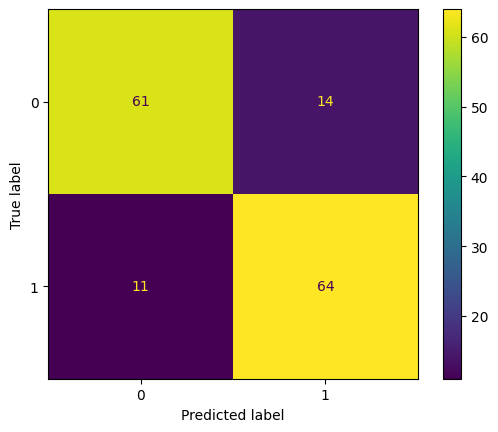

In [136]:
cm_xgb_smote = confusion_matrix(y_true = y_valid['smote'],
                            y_pred = y_valid_xgb_pred_smote)

disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_smote,
                               display_labels=grad_tree.classes_)
disp_cm.append(disp_3)

disp_3.plot()
plt.show()

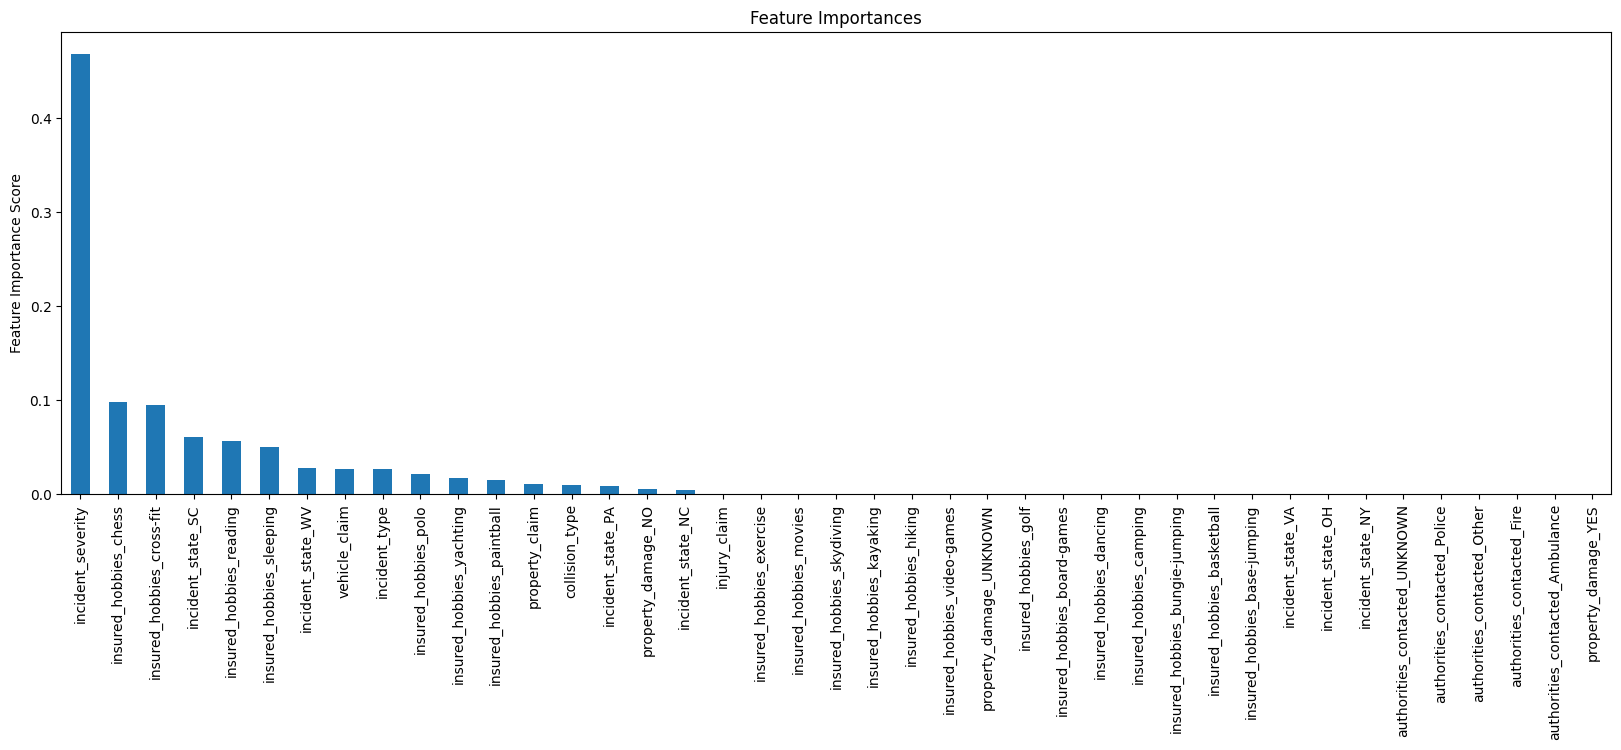

In [137]:
fig, ax = plt.subplots(figsize=(20,6))

feat_imp = pd.Series(xgb_smote.feature_importances_, x_valid['smote'].columns.to_list()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

### <a id='toc4_3_2_'></a>[Oversampling](#toc0_)
-----

In [138]:
xgb_over = XGBClassifier(
                    n_estimators = 7,
                    learning_rate = 0.7,
                    max_depth = 4,
                    scale_pos_weight = 0.4,
                    alpha = 5,
                    random_state=123)

xgb_over.fit(x_train["oversampling"], y_train["oversampling"])

XGBClassifier(alpha=5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.7, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=7, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [140]:
y_valid_xgb_pred_over = xgb_over.predict(x_valid['oversampling'])

print(classification_report(y_true = y_valid['oversampling'],
                            y_pred = y_valid_xgb_pred_over))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80        75
           1       0.82      0.73      0.77        75

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150



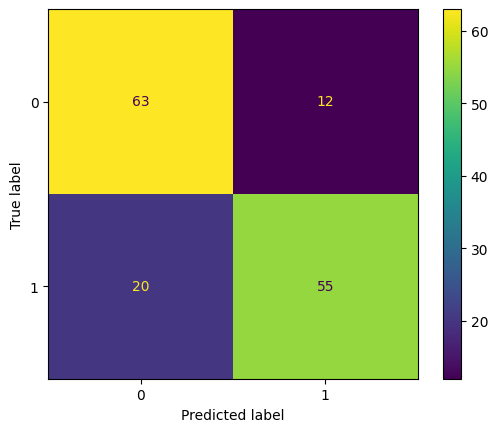

In [142]:
cm_xgb_over = confusion_matrix(y_true = y_valid['oversampling'],
                            y_pred = y_valid_xgb_pred_over)

disp_4 = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_over,
                               display_labels=grad_tree.classes_)

disp_cm.append(disp_4)
disp_4.plot()
plt.show()

In [ ]:
# util.pickle_dump(xgb, config_data['model_params_path'][6])

## <a id='toc4_4_'></a>[Decision Tree](#toc0_)

### <a id='toc4_4_1_'></a>[Smote](#toc0_)

In [37]:
dt_tree = DecisionTreeClassifier(
                                max_depth = 5,
                                random_state = 123)

dt_tree.fit(x_train["smote"], y_train["smote"])

y_dt_pred = dt_tree.predict(x_train["smote"])

accuracy_score(y_true=y_train["smote"],
               y_pred=y_dt_pred)

0.9194352159468439

In [38]:
y_valid_dt_smote = dt_tree.predict(x_valid)

print(classification_report(y_true = y_valid,
                            y_pred = y_valid_dt_smote))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86        75
           1       0.58      0.88      0.70        25

    accuracy                           0.81       100
   macro avg       0.77      0.83      0.78       100
weighted avg       0.86      0.81      0.82       100



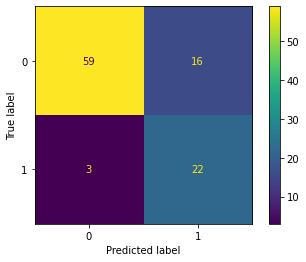

In [39]:
cm_dt = confusion_matrix(y_true = y_valid,
                            y_pred = y_valid_dt_smote)

disp_5 = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                               display_labels=grad_tree.classes_)

disp_cm.append(disp_5)
disp_5.plot()
plt.show()

## <a id='toc4_5_'></a>[ADABOOST](#toc0_)

### <a id='toc4_5_1_'></a>[Smote](#toc0_)
----------

In [166]:
    dist_params_ada = {
        "base_estimator" : [DecisionTreeClassifier(max_depth = 2)],
        "n_estimators" : [3],
        "learning_rate" : [0.7],
        "random_state": [123],
    }

In [167]:
ada_smote = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2),
                             n_estimators = 3,
                             learning_rate = 0.7,
                             random_state = 123)

ada_smote.fit(x_train['smote'], y_train['smote'])

c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.7, n_estimators=3, random_state=123)

In [170]:
y_valid_ada_smote = ada_smote.predict(x_valid['smote'])

print(classification_report(y_true = y_valid['smote'],
                            y_pred = y_valid_ada_smote))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87        75
           1       0.82      0.97      0.89        75

    accuracy                           0.88       150
   macro avg       0.89      0.88      0.88       150
weighted avg       0.89      0.88      0.88       150



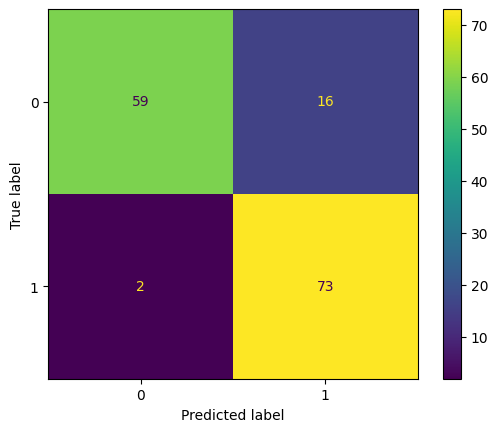

In [171]:
cm_ada = confusion_matrix(y_true = y_valid['smote'],
                      y_pred = y_valid_ada_smote)

disp_6 = ConfusionMatrixDisplay(confusion_matrix=cm_ada,
                               display_labels=ada_smote.classes_)

disp_cm.append(disp_6)
disp_6.plot()
plt.show()

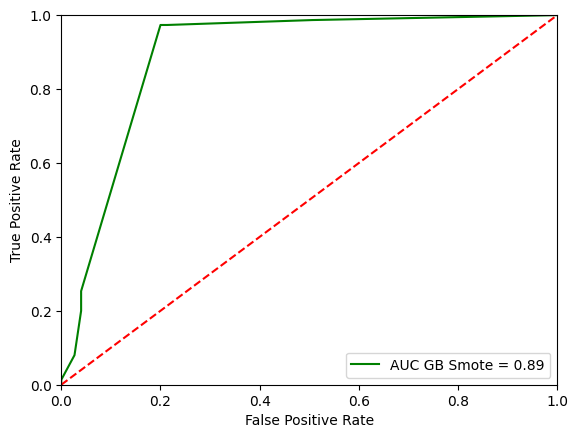

In [172]:
y_valid_ada_smote_proba = ada_smote.predict_proba(x_valid['smote'])
fpr_ada_smote, tpr_ada_smote, _ = roc_curve(y_valid['smote'],
                                                y_valid_ada_smote_proba[:, 1])

roc_auc_ada_smote = auc(fpr_ada_smote, tpr_ada_smote)
plt.plot(fpr_ada_smote, tpr_ada_smote, 'g', label = 'AUC GB Smote = %0.2f' % roc_auc_ada_smote)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## <a id='toc4_6_'></a>[<b>ROC Plot (Auc Score)</b>](#toc0_)
---------

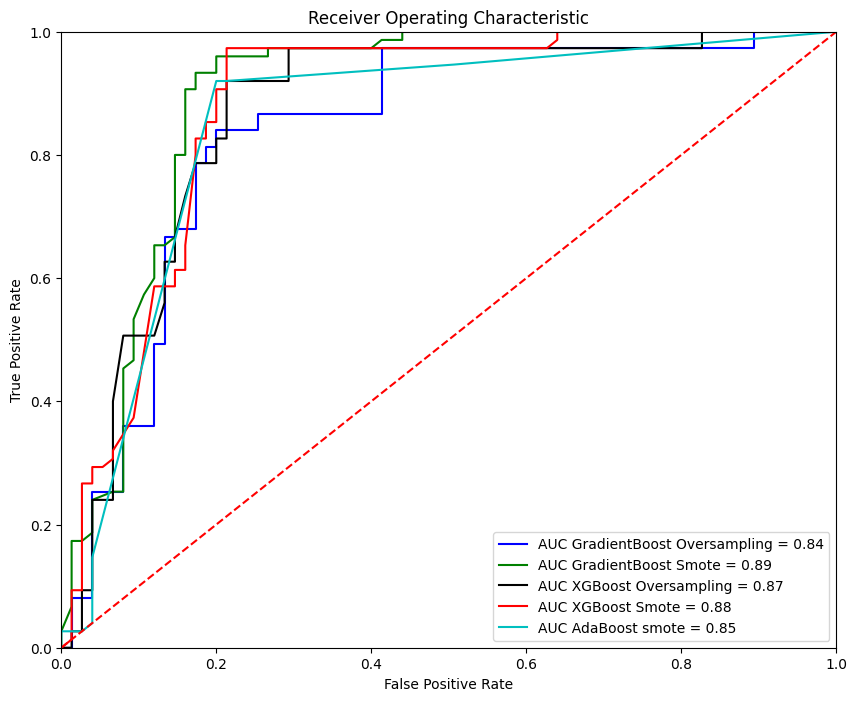

In [173]:
## Create Proba for all function
y_valid_xgb_over_proba = xgb_over.predict_proba(x_valid['oversampling'])
y_valid_xgb_smote_proba = xgb_smote.predict_proba(x_valid['smote'])
y_valid_ada_smote_proba = ada_smote.predict_proba(x_valid['oversampling'])
y_valid_gb_pred_over_proba = grad_tree.predict_proba(x_valid['oversampling'])
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_valid['smote'])

## ROC CURVE Function for create FPR & TPR
fpr_xgb_over, tpr_xgb_over, _ = roc_curve(y_valid['oversampling'],
                                         y_valid_xgb_over_proba[:, 1])
fpr_xgb_smote, tpr_xgb_smote, _ = roc_curve(y_valid['smote'],
                                         y_valid_xgb_smote_proba[:, 1])
fpr_ada_smote, tpr_ada_smote, _ = roc_curve(y_valid['smote'],
                                                           y_valid_ada_smote_proba[:, 1])
fpr_gb_over, tpr_gb_over, _ = roc_curve(y_valid['oversampling'],
                                         y_valid_gb_pred_over_proba[:, 1])

fpr_gb_smote, tpr_gb_smote, _ = roc_curve(y_valid['smote'],
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_xgb_over = auc(fpr_xgb_over, tpr_xgb_over)
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)
roc_auc_ada_smote = auc(fpr_ada_smote, tpr_ada_smote)
roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)


plt.subplots(figsize=(10,8))
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC GradientBoost Oversampling = %0.2f' % roc_auc_gb_over)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GradientBoost Smote = %0.2f' % roc_auc_gb_smote)
plt.plot(fpr_xgb_over, tpr_xgb_over, 'k', label = 'AUC XGBoost Oversampling = %0.2f' % roc_auc_xgb_over)
plt.plot(fpr_xgb_smote, tpr_xgb_smote, 'r', label = 'AUC XGBoost Smote = %0.2f' % roc_auc_xgb_smote)
plt.plot(fpr_ada_smote, tpr_ada_smote, 'c', label = 'AUC AdaBoost smote = %0.2f' % roc_auc_ada_smote)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# <a id='toc5_'></a>[<b> Hyperparameter Tuning</b>](#toc0_)

## <a id='toc5_1_'></a>[Create Param Distribution](#toc0_)
---

In [71]:
def create_dist_params(model_name: str) -> dict:
    # Define models paramteres   
    dist_params_xgb = {
        "n_estimators" : [7],
        "learning_rate" : [0.7],
        "max_depth" : [4],
        "alpha" : [5],
        "scale_pos_weight" : [0.4],
    }
    dist_params_gb = {
        "max_depth" : [2],
        "n_estimators" : [5],
        "learning_rate" : [0.5],
    }
    dist_params_ada = {
        "base_estimator" : [DecisionTreeClassifier(max_depth = 2)],
        "n_estimators" : [3],
        "learning_rate" : [0.7],
    }
    dist_params_dt = {
        "max_depth" : [5],
    }

    # Make all models parameters in to one
    dist_params = {
        "XGBClassifier": dist_params_xgb,
        "GradientBoostingClassifier": dist_params_gb,
        "AdaBoostClassifier": dist_params_ada,
        "DecisionTreeClassifier": dist_params_dt
    }

    # Return distribution of model parameters
    return dist_params[model_name]

In [72]:
def hyper_params_tuning(model: list) -> list:
    # Create copy of current best baseline model
    model_list = []
    trained_model = [XGBClassifier(),GradientBoostingClassifier(),AdaBoostClassifier(),DecisionTreeClassifier()]
    
    # Create model object
    for col, mod in list(zip(model, trained_model)):
        dist_params = create_dist_params(col)
        model_rsc = GridSearchCV(mod, dist_params, n_jobs = -1)
        model_ = {
                        "model_name": col,
                        "model_object": model_rsc,
                        "model_uid": ""
                    }
            
        model_list.append(model_.copy())
    
    # Return model object
    return model_list

### <a id='toc5_1_1_'></a>[run debugging](#toc0_)

In [ ]:
listmodel_ = hyper_params_tuning(['XGBClassifier',
                                  'GradientBoostingClassifier', 
                                  'AdaBoostClassifier',
                                  'DecisionTreeClassifier'])

listmodel_

In [ ]:
## Sanity Check
x_test.shape == x_valid.shape

## <a id='toc5_2_'></a>[Create Training Function based on Validation](#toc0_)
----

In [60]:
def train_eval_valid(configuration_model: str, params: dict, hyperparams_model: list = None):
    # Load dataset
    # x_train, y_train, \
    # x_valid, y_valid, \
    # x_test, y_test = load_dataset(params)

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_valid)
            performance = classification_report(y_valid, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["recall"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

## <a id='toc5_3_'></a>[Training model and update Training Logs](#toc0_)
---

In [73]:
list_of_trained_model_valid, \
training_log_valid = train_eval_valid("Hyperparams", 
                                    config_data,
                                    hyper_params_tuning(['XGBClassifier',
                                                          'GradientBoostingClassifier', 
                                                          'AdaBoostClassifier',
                                                          'DecisionTreeClassifier']))

2023-01-07 22:15:31.071627 creating training log template.
2023-01-07 22:15:31.071627 Training log template created.
2023-01-07 22:15:31.071627 Training model based on configuration data: nonbalance
2023-01-07 22:15:31.073625 Training model: XGBClassifier
2023-01-07 22:15:31.917829 Evalutaing model: XGBClassifier
2023-01-07 22:15:31.964822 Logging: XGBClassifier
2023-01-07 22:15:31.974823 Model XGBClassifier has been trained for configuration data nonbalance.
2023-01-07 22:15:31.974823 Training model: GradientBoostingClassifier
2023-01-07 22:15:32.217328 Evalutaing model: GradientBoostingClassifier
2023-01-07 22:15:32.237357 Logging: GradientBoostingClassifier
2023-01-07 22:15:32.244982 Model GradientBoostingClassifier has been trained for configuration data nonbalance.
2023-01-07 22:15:32.244982 Training model: AdaBoostClassifier
2023-01-07 22:15:32.498412 Evalutaing model: AdaBoostClassifier
2023-01-07 22:15:32.547412 Logging: AdaBoostClassifier
2023-01-07 22:15:32.553410 Model AdaBo

## <a id='toc5_4_'></a>[Best Model Overview](#toc0_)
----

In [91]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
pd.DataFrame(training_log_valid)[['model_name',
                                 'training_time',
                                 'performance',
                                 'f1_score_avg']].sort_values(["f1_score_avg", "training_time"], ascending = [False, True])

,model_name,training_time,performance,f1_score_avg
4,Hyperparams-smote-XGBClassifier,0.952034,"{'0': {'precision': 0.8717948717948718, 'recall': 0.9066666666666666, 'f1-score': 0.8888888888888887, 'support': 75}, '1': {'precision': 0.6818181818181818, 'recall': 0.6, 'f1-score': 0.6382978723404256, 'support': 25}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7768065268065267, 'recall': 0.7533333333333333, 'f1-score': 0.7635933806146571, 'support': 100}, 'weighted avg': {'precision': 0.8243006993006994, 'recall': 0.83, 'f1-score': 0.826241134751773, 'support': 100}}",0.83
9,Hyperparams-oversampling-GradientBoostingClassifier,0.445997,"{'0': {'precision': 0.9672131147540983, 'recall': 0.7866666666666666, 'f1-score': 0.8676470588235293, 'support': 75}, '1': {'precision': 0.5897435897435898, 'recall': 0.92, 'f1-score': 0.71875, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7784783522488441, 'recall': 0.8533333333333333, 'f1-score': 0.7931985294117647, 'support': 100}, 'weighted avg': {'precision': 0.8728457335014713, 'recall': 0.82, 'f1-score': 0.830422794117647, 'support': 100}}",0.82
10,Hyperparams-oversampling-AdaBoostClassifier,0.507705,"{'0': {'precision': 0.9672131147540983, 'recall': 0.7866666666666666, 'f1-score': 0.8676470588235293, 'support': 75}, '1': {'precision': 0.5897435897435898, 'recall': 0.92, 'f1-score': 0.71875, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7784783522488441, 'recall': 0.8533333333333333, 'f1-score': 0.7931985294117647, 'support': 100}, 'weighted avg': {'precision': 0.8728457335014713, 'recall': 0.82, 'f1-score': 0.830422794117647, 'support': 100}}",0.82
6,Hyperparams-smote-AdaBoostClassifier,0.569004,"{'0': {'precision': 0.9384615384615385, 'recall': 0.8133333333333334, 'f1-score': 0.8714285714285714, 'support': 75}, '1': {'precision': 0.6, 'recall': 0.84, 'f1-score': 0.7000000000000001, 'support': 25}, 'accuracy': 0.82, 'macro avg': {'precision': 0.7692307692307692, 'recall': 0.8266666666666667, 'f1-score': 0.7857142857142858, 'support': 100}, 'weighted avg': {'precision': 0.8538461538461539, 'recall': 0.82, 'f1-score': 0.8285714285714286, 'support': 100}}",0.82
2,Hyperparams-nonbalance-AdaBoostClassifier,0.252431,"{'0': {'precision': 0.9242424242424242, 'recall': 0.8133333333333334, 'f1-score': 0.8652482269503545, 'support': 75}, '1': {'precision': 0.5882352941176471, 'recall': 0.8, 'f1-score': 0.6779661016949153, 'support': 25}, 'accuracy': 0.81, 'macro avg': {'precision': 0.7562388591800356, 'recall': 0.8066666666666666, 'f1-score': 0.771607164322635, 'support': 100}, 'weighted avg': {'precision': 0.8402406417112299, 'recall': 0.81, 'f1-score': 0.8184276956364946, 'support': 100}}",0.81
5,Hyperparams-smote-GradientBoostingClassifier,0.633001,"{'0': {'precision': 0.9375, 'recall': 0.8, 'f1-score': 0.8633093525179856, 'support': 75}, '1': {'precision': 0.5833333333333334, 'recall': 0.84, 'f1-score': 0.6885245901639344, 'support': 25}, 'accuracy': 0.81, 'macro avg': {'precision': 0.7604166666666667, 'recall': 0.8200000000000001, 'f1-score': 0.7759169713409599, 'support': 100}, 'weighted avg': {'precision': 0.8489583333333333, 'recall': 0.81, 'f1-score': 0.8196131619294728, 'support': 100}}",0.81
3,Hyperparams-nonbalance-DecisionTreeClassifier,0.170997,"{'0': {'precision': 0.8767123287671232, 'recall': 0.8533333333333334, 'f1-score': 0.8648648648648648, 'support': 75}, '1': {'precision': 0.5925925925925926, 'recall': 0.64, 'f1-score': 0.6153846153846153, 'support': 25}, 'accuracy': 0.8, 'macro avg': {'precision': 0.7346524606798579, 'recall': 0.7466666666666667, 'f1-score': 0.74012474012474, 'support': 100}, 'weighted avg': {'precision': 0.8056823947234905, 'recall': 0.8, 'f1-score': 0.8024948024948024, 'support': 100}}",0.80
11,Hyperparams-oversampling-DecisionTreeClassifier,0.446059,"{'0': {'precision': 0.9365079365079365, 'recall': 0.7866666666666666, 'f1-score': 0.8550724637681159, 'support': 75}, '1': {'precision': 0.5675675675675675, 'recall': 0.84, 'f1-

# <a id='toc6_'></a>[<b>Test Data</b>](#toc0_)

## <a id='toc6_1_'></a>[Create ROC Curve toward Test Set](#toc0_)
----

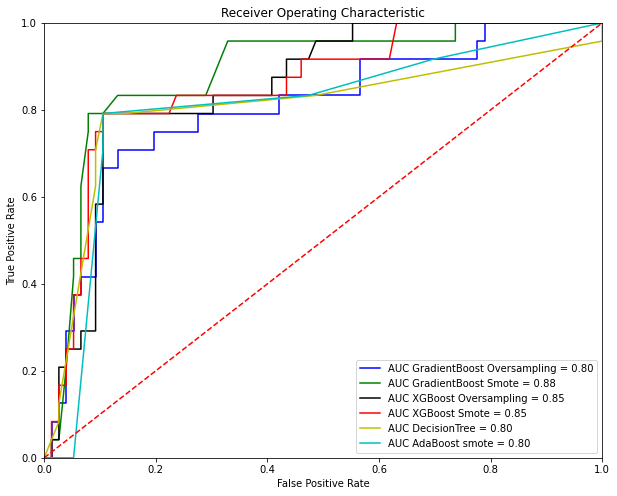

In [97]:
## Create Proba for all function
y_valid_xgb_over_proba = xgb_over.predict_proba(x_test)
y_valid_xgb_smote_proba = xgb_smote.predict_proba(x_test)
y_valid_dt_proba = dt_tree.predict_proba(x_test)
y_valid_ada_over_proba = ada_over.predict_proba(x_test)
y_valid_gb_pred_over_proba = grad_tree.predict_proba(x_test)
y_valid_gb_pred_smote_proba = grad_tree_smote.predict_proba(x_test)

## ROC CURVE Function for create FPR & TPR
fpr_xgb_over, tpr_xgb_over, threshold_xgb_over = roc_curve(y_test,
                                         y_valid_xgb_over_proba[:, 1])
fpr_xgb_smote, tpr_xgb_smote, threshold_xgb_smote = roc_curve(y_test,
                                         y_valid_xgb_smote_proba[:, 1])
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test,
                                        y_valid_dt_proba[:, 1])
fpr_ada_over, tpr_ada_over, threshold_ada_over = roc_curve(y_test,
                                                           y_valid_ada_over_proba[:, 1])
fpr_gb_over, tpr_gb_over, threshold_gb_over = roc_curve(y_test,
                                         y_valid_gb_pred_over_proba[:, 1])

fpr_gb_smote, tpr_gb_smote, threshold_gb_smote = roc_curve(y_test,
                                         y_valid_gb_pred_smote_proba[:, 1])

roc_auc_xgb_over = auc(fpr_xgb_over, tpr_xgb_over)
roc_auc_xgb_smote = auc(fpr_xgb_smote, tpr_xgb_smote)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_ada_over = auc(fpr_ada_over, tpr_ada_over)
roc_auc_gb_over = auc(fpr_gb_over, tpr_gb_over)
roc_auc_gb_smote = auc(fpr_gb_smote, tpr_gb_smote)


plt.subplots(figsize=(10,8))
plt.title('Receiver Operating Characteristic')

plt.plot(fpr_gb_over, tpr_gb_over, 'b', label = 'AUC GradientBoost Oversampling = %0.2f' % roc_auc_gb_over)
plt.plot(fpr_gb_smote, tpr_gb_smote, 'g', label = 'AUC GradientBoost Smote = %0.2f' % roc_auc_gb_smote)
plt.plot(fpr_xgb_over, tpr_xgb_over, 'k', label = 'AUC XGBoost Oversampling = %0.2f' % roc_auc_xgb_over)
plt.plot(fpr_xgb_smote, tpr_xgb_smote, 'r', label = 'AUC XGBoost Smote = %0.2f' % roc_auc_xgb_smote)
plt.plot(fpr_dt, tpr_dt, 'y', label = 'AUC DecisionTree = %0.2f' % roc_auc_dt)
plt.plot(fpr_ada_over, tpr_ada_over, 'c', label = 'AUC AdaBoost smote = %0.2f' % roc_auc_ada_over)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## <a id='toc6_2_'></a>[Create Function to Eval Test Data](#toc0_)
----

In [63]:
def train_eval_test(configuration_model: str, params: dict, hyperparams_model: list = None):

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = util.time_stamp()
            model["model_object"].fit(x_train_data, y_train_data)
            training_time = (util.time_stamp() - training_time).total_seconds()

            # Debug message
            util.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(x_test)
            performance = classification_report(y_test, y_predict, output_dict = True)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}-{}".format(configuration_model, config_data, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["weighted avg"]["recall"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

## <a id='toc6_3_'></a>[Training Dataset and Update Training Logs](#toc0_)
---

In [75]:
list_of_trained_model_test, \
training_log_test = train_eval_test("Hyperparams", 
                                    config_data,
                                    hyper_params_tuning(['XGBClassifier',
                                                          'GradientBoostingClassifier', 
                                                          'AdaBoostClassifier',
                                                          'DecisionTreeClassifier']))

2023-01-07 22:16:01.574957 creating training log template.
2023-01-07 22:16:01.575956 Training log template created.
2023-01-07 22:16:01.575956 Training model based on configuration data: nonbalance
2023-01-07 22:16:01.577959 Training model: XGBClassifier
2023-01-07 22:16:02.180261 Evalutaing model: XGBClassifier
2023-01-07 22:16:02.232262 Logging: XGBClassifier
2023-01-07 22:16:02.244276 Model XGBClassifier has been trained for configuration data nonbalance.
2023-01-07 22:16:02.244276 Training model: GradientBoostingClassifier
2023-01-07 22:16:02.539229 Evalutaing model: GradientBoostingClassifier
2023-01-07 22:16:02.562647 Logging: GradientBoostingClassifier
2023-01-07 22:16:02.569643 Model GradientBoostingClassifier has been trained for configuration data nonbalance.
2023-01-07 22:16:02.569643 Training model: AdaBoostClassifier
2023-01-07 22:16:02.815179 Evalutaing model: AdaBoostClassifier
2023-01-07 22:16:02.840880 Logging: AdaBoostClassifier
2023-01-07 22:16:02.844880 Model AdaBo

## <a id='toc6_4_'></a>[Check Best Model](#toc0_)
---

In [93]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')
pd.DataFrame(training_log_test)[['model_name',
                                 'training_time',
                                 'performance',
                                 'f1_score_avg']].sort_values(["f1_score_avg", "training_time"], ascending = [False, True])

,model_name,training_time,performance,f1_score_avg
5,Hyperparams-smote-GradientBoostingClassifier,0.509681,"{'0': {'precision': 0.9333333333333333, 'recall': 0.9210526315789473, 'f1-score': 0.9271523178807947, 'support': 76}, '1': {'precision': 0.76, 'recall': 0.7916666666666666, 'f1-score': 0.7755102040816326, 'support': 24}, 'accuracy': 0.89, 'macro avg': {'precision': 0.8466666666666667, 'recall': 0.8563596491228069, 'f1-score': 0.8513312609812136, 'support': 100}, 'weighted avg': {'precision': 0.8917333333333335, 'recall': 0.89, 'f1-score': 0.8907582105689958, 'support': 100}}",0.89
10,Hyperparams-oversampling-AdaBoostClassifier,0.439040,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
9,Hyperparams-oversampling-GradientBoostingClassifier,0.470805,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
7,Hyperparams-smote-DecisionTreeClassifier,0.333900,"{'0': {'precision': 0.918918918918919, 'recall': 0.8947368421052632, 'f1-score': 0.9066666666666667, 'support': 76}, '1': {'precision': 0.6923076923076923, 'recall': 0.75, 'f1-score': 0.7199999999999999, 'support': 24}, 'accuracy': 0.86, 'macro avg': {'precision': 0.8056133056133057, 'recall': 0.8223684210526316, 'f1-score': 0.8133333333333332, 'support': 100}, 'weighted avg': {'precision': 0.8645322245322246, 'recall': 0.86, 'f1-score': 0.8618666666666667, 'support': 100}}",0.86
6,Hyperparams-smote-AdaBoostClassifier,0.501836,"{'0': {'precision': 0.875, 'recall': 0.9210526315789473, 'f1-score': 0.8974358974358975, 'support': 76}, '1': {'precision': 0.7, 'recall': 0.5833333333333334, 'f1-score': 0.6363636363636365, 'support': 24}, 'accuracy': 0.84, 'macro avg': {'precision': 0.7875, 'recall': 0.7521929824561404, 'f1-score': 0.766899766899767, 'support': 100}, 'weighted avg': {'precision': 0.833, 'recall': 0.84, 'f1-score': 0.8347785547785549, 'support': 100}}",0.84
2,Hyperparams-nonbalance-AdaBoostClassifier,0.243534,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
4,Hyperparams-smote-XGBClassifier,0.899158,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
3,Hyperparams-nonbalance-DecisionTreeClassifier,0.180763,"{'0': {'precision': 0.8625, 'recall': 0.9078947368421053, 'f1-score': 0.8846153846153847, 'support': 76}, 

## <a id='toc6_5_'></a>[Save Production Model](#toc0_)
-----

In [106]:
model_test, \
production_model_log_test, \
training_logs_test = get_production_model(list_of_trained_model_test, 
                                          training_log_test, 
                                          config_data)

2023-01-07 23:21:23.121474 Choosing model by metrics score.
2023-01-07 23:21:23.121474 Converting training log type of data from dict to dataframe.
2023-01-07 23:21:23.128473 Trying to load previous production model.
2023-01-07 23:21:23.176474 Previous production model loaded.
2023-01-07 23:21:23.176474 Loading validation data.
2023-01-07 23:21:23.176474 Checking compatibilty previous production model's input with current train data's features.
2023-01-07 23:21:23.177473 Features compatible.
2023-01-07 23:21:23.177473 Reassesing previous model performance using current validation data.
2023-01-07 23:21:23.206476 Assessing complete.
2023-01-07 23:21:23.206476 Storing new metrics data to previous model structure.
2023-01-07 23:21:23.206476 Adding previous model data to current training log and list of model
2023-01-07 23:21:23.216478 Sorting training log by f1 macro avg and training time.
2023-01-07 23:21:23.221474 Searching model data based on sorted training log.
2023-01-07 23:21:23.25

# <a id='toc7_'></a>[<b>Show Best Final Model</b>](#toc0_)
----

In [107]:
pd.set_option('display.max_colwidth', None)
# pd.reset_option('display.max_colwidth')

training_logs_test[["model_name","training_time","performance","f1_score_avg"]].sort_values(["f1_score_avg"], ascending=False)

,model_name,training_time,performance,f1_score_avg
5,Hyperparams-smote-GradientBoostingClassifier,0.509681,"{'0': {'precision': 0.9333333333333333, 'recall': 0.9210526315789473, 'f1-score': 0.9271523178807947, 'support': 76}, '1': {'precision': 0.76, 'recall': 0.7916666666666666, 'f1-score': 0.7755102040816326, 'support': 24}, 'accuracy': 0.89, 'macro avg': {'precision': 0.8466666666666667, 'recall': 0.8563596491228069, 'f1-score': 0.8513312609812136, 'support': 100}, 'weighted avg': {'precision': 0.8917333333333335, 'recall': 0.89, 'f1-score': 0.8907582105689958, 'support': 100}}",0.89
9,Hyperparams-oversampling-GradientBoostingClassifier,0.470805,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
10,Hyperparams-oversampling-AdaBoostClassifier,0.439040,"{'0': {'precision': 0.9315068493150684, 'recall': 0.8947368421052632, 'f1-score': 0.912751677852349, 'support': 76}, '1': {'precision': 0.7037037037037037, 'recall': 0.7916666666666666, 'f1-score': 0.7450980392156864, 'support': 24}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8176052765093861, 'recall': 0.8432017543859649, 'f1-score': 0.8289248585340177, 'support': 100}, 'weighted avg': {'precision': 0.8768340943683408, 'recall': 0.87, 'f1-score': 0.87251480457955, 'support': 100}}",0.87
7,Hyperparams-smote-DecisionTreeClassifier,0.333900,"{'0': {'precision': 0.918918918918919, 'recall': 0.8947368421052632, 'f1-score': 0.9066666666666667, 'support': 76}, '1': {'precision': 0.6923076923076923, 'recall': 0.75, 'f1-score': 0.7199999999999999, 'support': 24}, 'accuracy': 0.86, 'macro avg': {'precision': 0.8056133056133057, 'recall': 0.8223684210526316, 'f1-score': 0.8133333333333332, 'support': 100}, 'weighted avg': {'precision': 0.8645322245322246, 'recall': 0.86, 'f1-score': 0.8618666666666667, 'support': 100}}",0.86
6,Hyperparams-smote-AdaBoostClassifier,0.501836,"{'0': {'precision': 0.875, 'recall': 0.9210526315789473, 'f1-score': 0.8974358974358975, 'support': 76}, '1': {'precision': 0.7, 'recall': 0.5833333333333334, 'f1-score': 0.6363636363636365, 'support': 24}, 'accuracy': 0.84, 'macro avg': {'precision': 0.7875, 'recall': 0.7521929824561404, 'f1-score': 0.766899766899767, 'support': 100}, 'weighted avg': {'precision': 0.833, 'recall': 0.84, 'f1-score': 0.8347785547785549, 'support': 100}}",0.84
2,Hyperparams-nonbalance-AdaBoostClassifier,0.243534,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
4,Hyperparams-smote-XGBClassifier,0.899158,"{'0': {'precision': 0.8641975308641975, 'recall': 0.9210526315789473, 'f1-score': 0.89171974522293, 'support': 76}, '1': {'precision': 0.6842105263157895, 'recall': 0.5416666666666666, 'f1-score': 0.6046511627906976, 'support': 24}, 'accuracy': 0.83, 'macro avg': {'precision': 0.7742040285899935, 'recall': 0.7313596491228069, 'f1-score': 0.7481854540068138, 'support': 100}, 'weighted avg': {'precision': 0.8210006497725796, 'recall': 0.83, 'f1-score': 0.8228232854391941, 'support': 100}}",0.83
3,Hyperparams-nonbalance-DecisionTreeClassifier,0.180763,"{'0': {'precision': 0.8625, 'recall': 0.9078947368421053, 'f1-score': 0.8846153846153847, 'support': 76}, 

In [108]:
model_test["model_data"]["model_object"]

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5], 'max_depth': [2],
                         'n_estimators': [5]})

# <a id='toc8_'></a>[<b> Check Production Model</b>](#toc0_)
---

In [178]:
check_model = util.pickle_load(config_data['production_model_path'])

In [179]:
check_model

{'model_data': {'model_name': 'GradientBoostingClassifier',
  'model_object': GradientBoostingClassifier(),
  'model_uid': '121a8caff5efea786a968ad0e31b1e5a'},
 'model_log': {'model_name': 'Production-GradientBoostingClassifier',
  'model_uid': '121a8caff5efea786a968ad0e31b1e5a',
  'training_time': 0.536438,
  'training_date': '2023-07-30 13:15:27.639259',
  'performance': {'0': {'precision': 0.9523809523809523,
    'recall': 0.8,
    'f1-score': 0.8695652173913043,
    'support': 75.0},
   '1': {'precision': 0.8275862068965517,
    'recall': 0.96,
    'f1-score': 0.888888888888889,
    'support': 75.0},
   'accuracy': 0.88,
   'macro avg': {'precision': 0.8899835796387521,
    'recall': 0.88,
    'f1-score': 0.8792270531400966,
    'support': 150.0},
   'weighted avg': {'precision': 0.8899835796387521,
    'recall': 0.88,
    'f1-score': 0.8792270531400966,
    'support': 150.0}},
  'f1_score_avg': 0.8792270531400966,
  'data_configurations': 'smote'}}